In [ ]:
# Load the dataset
import pandas as pd

# Replace with the actual file path to your dataset
df = pd.read_csv("Toddler Autism dataset July 2018.csv")

# Check the distribution of the target variable
class_distribution = df["Class/ASD Traits "].value_counts()

# Print the counts
print("Distribution of Samples in the Dataset:")
print(f"Autism (Yes): {class_distribution.get('Yes', 0)}")
print(f"No Autism (No): {class_distribution.get('No', 0)}")


Distribution of Samples in the Dataset:
Autism (Yes): 728
No Autism (No): 326


In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
import pandas as pd

#columns_to_drop = ["Case_No", "Ethnicity", "Jaundice", "Family_mem_with_ASD", "Qchat-10-Score", "Who completed the test"]
#df = df.drop(columns=columns_to_drop)

# Convert 'Sex' column to numeric
df["Sex"] = df["Sex"].map({"m": 1, "f": 0})

# Separate features and target
X = df.drop(columns=["Class/ASD Traits "])  # Features
y = df["Class/ASD Traits "].map({"Yes": 1, "No": 0})  # Target (binary)

# Step 1: Oversample the minority class using SMOTE
smote = SMOTE(sampling_strategy=500/728, random_state=42)  # Generate minority samples to reach 500
X_resampled, y_resampled = smote.fit_resample(X, y)

# Step 2: Convert resampled data back to DataFrame
df_resampled = pd.concat(
    [pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled, name="Class/ASD Traits ")],
    axis=1,
)
df_resampled["Class/ASD Traits "] = df_resampled["Class/ASD Traits "].map({1: "Yes", 0: "No"})

# Step 3: Undersample the majority class to 500 samples
df_majority = df_resampled[df_resampled["Class/ASD Traits "] == "Yes"]
df_minority = df_resampled[df_resampled["Class/ASD Traits "] == "No"]

df_majority_downsampled = resample(
    df_majority, replace=False, n_samples=500, random_state=42
)

# Step 4: Combine balanced data and shuffle
df_balanced = pd.concat([df_majority_downsampled, df_minority]).sample(frac=1, random_state=42)

# Verify the class distribution
print("Balanced Dataset Distribution:")
print(df_balanced["Class/ASD Traits "].value_counts())

# Save the balanced dataset
df_balanced.to_csv("balanced_autism_dataset.csv", index=False)
print("\nBalanced dataset saved as 'balanced_autism_dataset.csv'")

Balanced Dataset Distribution:
Class/ASD Traits 
No     500
Yes    500
Name: count, dtype: int64

Balanced dataset saved as 'balanced_autism_dataset.csv'


Accuracy: 0.99

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       100
           1       1.00      0.99      0.99       100

    accuracy                           0.99       200
   macro avg       1.00      0.99      0.99       200
weighted avg       1.00      0.99      0.99       200



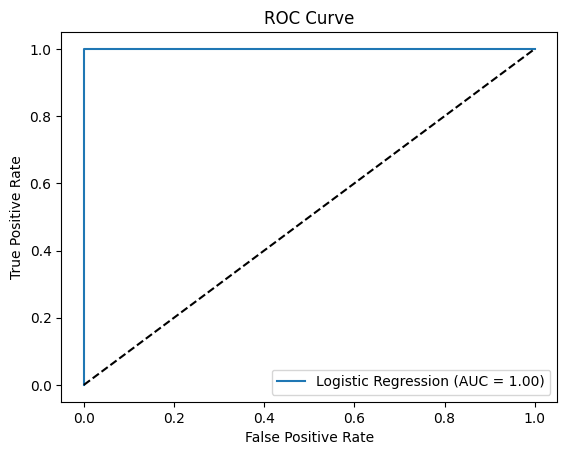


Feature Importance (Logistic Regression):
A2: 2.8358
A9: 2.7129
A4: 2.5222
A8: 2.4021
A7: 2.3924
A5: 2.3863
A6: 2.3457
A10: 2.0671
A1: 2.0192
A3: 1.9457
Sex: 0.2458
Age_Mons: 0.0184


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("balanced_autism_dataset.csv")

# Split features and target
X = df.drop(columns=["Class/ASD Traits "])  # Drop Class and Score columns
y = df["Class/ASD Traits "].map({"Yes": 1, "No": 0})  # Map target to binary

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train Logistic Regression
model_lr = LogisticRegression(max_iter=1000, random_state=42)
model_lr.fit(X_train, y_train)

# Predict and evaluate
y_pred = model_lr.predict(X_test)
y_proba = model_lr.predict_proba(X_test)[:, 1]  # For AUC-ROC

# Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# AUC-ROC Curve
roc_auc = roc_auc_score(y_test, y_proba)
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure()
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Coefficients and feature importance
coef_dict = {feature: coef for feature, coef in zip(X.columns, model_lr.coef_[0])}
sorted_coef = sorted(coef_dict.items(), key=lambda x: abs(x[1]), reverse=True)

print("\nFeature Importance (Logistic Regression):")
for feature, coef in sorted_coef:
    print(f"{feature}: {coef:.4f}")


In [ ]:
import joblib
joblib.dump(model_lr, "ASQmodel.pkl")

['ASQmodel.pkl']

Accuracy (Random Forest): 0.98

Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       100
           1       0.99      0.97      0.98       100

    accuracy                           0.98       200
   macro avg       0.98      0.98      0.98       200
weighted avg       0.98      0.98      0.98       200



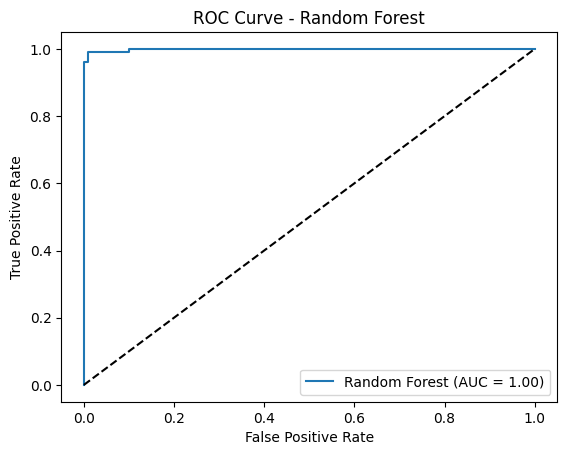


Feature Importances (Random Forest):
A9          0.178809
A6          0.141572
A5          0.131240
A7          0.102365
A2          0.098621
A1          0.090841
A4          0.083208
A8          0.053158
Age_Mons    0.046987
A3          0.034068
A10         0.027439
Sex         0.011691
dtype: float64


In [ ]:
# Import Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Train Random Forest
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = model_rf.predict(X_test)
y_proba_rf = model_rf.predict_proba(X_test)[:, 1]  # For AUC-ROC

# Evaluation metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy (Random Forest): {accuracy_rf:.2f}")
print("\nClassification Report (Random Forest):")
print(classification_report(y_test, y_pred_rf))

# AUC-ROC Curve
roc_auc_rf = roc_auc_score(y_test, y_proba_rf)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)

plt.figure()
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_rf:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.show()

# Feature Importance
feature_importances_rf = pd.Series(model_rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nFeature Importances (Random Forest):")
print(feature_importances_rf)


In [ ]:
def infer_asd_with_reasons(asq_model_path, input_features):
    """
    Infer whether a child has ASD traits using the ASQ model and provide reasons for ASD.

    Parameters:
    - asq_model_path (str): Path to the saved logistic regression model (e.g., 'asq_model.pkl').
    - input_features (dict): A dictionary of input features with keys corresponding to model features.

    Returns:
    - dict: Prediction results with 'ASD_Traits', 'Probability_Percentage', 'Explanation', and 'Reasons'.
    """
    # Load the trained model
    model = joblib.load(asq_model_path)

    # Define reasons corresponding to each feature
    reasons_dict = {
        "A1": "He/she does not look at someone when being called.",
        "A2": "It is not easy to get eye contact with him/her.",
        "A3": "He/she does not point to indicate wants.",
        "A4": "He/she does not point to share interests.",
        "A5": "He/she does not engage in pretend play.",
        "A6": "He/she does not follow where others are looking.",
        "A7": "He/she does not show signs of comforting upset family members.",
        "A8": "His/her first word is not easily describable.",
        "A9": "He/she does not use simple gestures like waving goodbye.",
        "A10": "He/she does not stare at nothing with no apparent purpose.",
    }

    # Convert input features to a DataFrame
    input_data = pd.DataFrame([input_features])

    # Predict using the model
    prediction = model.predict(input_data)
    prediction_proba = model.predict_proba(input_data)[:, 1]

    # Prepare reasons for ASD traits
    reasons = []
    if prediction[0] == 1:  # Only include reasons if ASD is predicted
        for feature, value in input_features.items():
            if feature in reasons_dict and value == 1:  # Check if feature contributes to ASD
                reasons.append(reasons_dict[feature])

    # Prepare results
    result = {
        "ASD_Traits": "Yes" if prediction[0] == 1 else "No",
        "Probability_Percentage": f"{round(prediction_proba[0] * 100, 2)}%",
        "Explanation": "The model predicts the child has ASD traits." if prediction[0] == 1
                       else "The model predicts the child does not have ASD traits.",
        "Reasons": reasons if reasons else "No behavioral indicators suggest ASD traits.",
    }
    return result


# Example usage
if __name__ == "__main__":
    # Example input features (replace with actual input data)
    input_features = {
        "A1": 0, "A2": 0, "A3": 0, "A4": 1, "A5": 1,
        "A6": 0, "A7": 0, "A8": 0, "A9": 1, "A10": 0,
        "Age_Mons": 36,
        "Sex": 1,  # 1 for male, 0 for female
    }

    # Path to the saved model
    asq_model_path = "ASQmodel.pkl"

    # Run inference
    result = infer_asd_with_reasons(asq_model_path, input_features)
    print("\nPrediction Results:")
    print(f"ASD Traits: {result['ASD_Traits']}")
    print(f"Probability of ASD Traits: {result['Probability_Percentage']}")
    print(f"Explanation: {result['Explanation']}")
    if result["ASD_Traits"] == "Yes":
        print("\nReasons for ASD in child:")
        for reason in result["Reasons"]:
            print(f"- {reason}")
    else:
        print(f"Reasons: {result['Reasons']}")



Prediction Results:
ASD Traits: No
Probability of ASD Traits: 35.26%
Explanation: The model predicts the child does not have ASD traits.
Reasons: No behavioral indicators suggest ASD traits.


In [ ]:
import pandas as pd
from sklearn.utils import resample

# Load the balanced dataset
df_balanced = pd.read_csv("balanced_autism_dataset.csv")  # Load the balanced dataset

# Separate classes in the balanced dataset
df_yes = df_balanced[df_balanced["Class/ASD Traits "] == "Yes"]
df_no = df_balanced[df_balanced["Class/ASD Traits "] == "No"]

# Randomly sample 500 rows from each class (with replacement if needed)
df_yes_sampled = resample(df_yes, replace=True, n_samples=500, random_state=42)
df_no_sampled = resample(df_no, replace=True, n_samples=500, random_state=42)

# Combine the sampled rows to form the meta-model test dataset
df_meta_model_test = pd.concat([df_yes_sampled, df_no_sampled]).sample(frac=1, random_state=42)

# Save the final 500-500 meta-model test dataset
df_meta_model_test.to_csv("meta_model_test_dataset.csv", index=False)
print("Meta-model test dataset saved as 'meta_model_test_dataset.csv'.")

# Verify the distribution in the meta-model test dataset
print("\nClass Distribution in Meta-Model Test Dataset:")
print(df_meta_model_test["Class/ASD Traits "].value_counts())


Meta-model test dataset saved as 'meta_model_test_dataset.csv'.

Class Distribution in Meta-Model Test Dataset:
Class/ASD Traits 
No     500
Yes    500
Name: count, dtype: int64


In [ ]:
import pandas as pd
import joblib

# Load the saved logistic regression model
model_lr = joblib.load("ASQmodel.pkl")

# Load the test dataset
df_test = pd.read_csv("/content/meta_model_test_dataset.csv")

# Prepare an empty list to store results
results = []

# Iterate through each row for inference
for index, row in df_test.iterrows():
    # Extract feature values with column names
    features = row.drop(labels=["Class/ASD Traits "]).to_frame().T  # Retain feature names by creating a DataFrame

    # Run inference
    autism_probability = model_lr.predict_proba(features)[0, 1]  # Probability of Autism (class 1)
    autism_marker = model_lr.predict(features)[0]  # Predicted marker (0 or 1)

    # Add the results to the list
    results.append({
        "S_No": index + 1,  # Serial number
        "Percentage_of_Autism": round(autism_probability * 100, 2),  # Probability as a percentage
        "Marker": autism_marker,  # Predicted class
    })

# Convert results to a DataFrame
df_results_output = pd.DataFrame(results)

# Save the results to a new CSV file
df_results_output.to_csv("meta_data_ASQ_results.csv", index=False)
print("Inference results saved as 'meta_data_ASQ_results.csv'.")


Inference results saved as 'meta_data_ASQ_results.csv'.
